<a href="https://colab.research.google.com/github/Snafkin547/Quantum-ML/blob/main/QML_Ch13_Search_and_Amplifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install numpy scipy matplotlib ipython pandas sympy nose seaborn
!pip install scikit-learn
!pip install pylatexenc ipywidgets qutip
!pip install kaggle

from google.colab import drive
import os

#Google Drive mounting to Google Colab
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/QML/Kaggle"
#Change the working directory
%cd /content/gdrive/My Drive/QML/Kaggle/

#Check if the directory was properly changed
%pwd

import pandas as pd

train=pd.read_csv('./train.csv')

In [ ]:
def evaluate_relation(relation, value):
  population=train[train[relation]==value] if value<2 else train[train[relation]>=value]
  p=len(population)/len(train)

  surv=population[population['Survived']==1]
  p_surv=len(surv)/len(population)
  return (p, p_surv)

In [ ]:
print("No Sibling: {:.2f} of the passengers, survival: {:.2f}".format(*evaluate_relation("SibSp", 0)))
print("One Sibling: {:.2f} of the passengers, survival: {:.2f}".format(*evaluate_relation("SibSp", 1)))
print("More Siblings: {:.2f} of the passengers, survival: {:.2f}".format(*evaluate_relation("SibSp", 2)))
print()
print("No Parent/Child: {:.2f} of the passengers, survival: {:.2f}".format(*evaluate_relation("Parch", 0)))
print("One Parent/Child: {:.2f} of the passengers, survival: {:.2f}".format(*evaluate_relation("Parch", 1)))
print("More Parents/Children: {:.2f} of the passengers, survival: {:.2f}".format(*evaluate_relation("Parch", 2)))

No Sibling: 0.68 of the passengers, survival: 0.35
One Sibling: 0.23 of the passengers, survival: 0.54
More Siblings: 0.08 of the passengers, survival: 0.27

No Parent/Child: 0.76 of the passengers, survival: 0.34
One Parent/Child: 0.13 of the passengers, survival: 0.55
More Parents/Children: 0.11 of the passengers, survival: 0.46


In [ ]:
train[train["PassengerId"]==250]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0,NaN,S


In [ ]:
current_passenger=train[train["PassengerId"]==250]
last_name=current_passenger["Name"].to_string(index=False).split(',')[0].lstrip()
train[train["Name"].str.contains(last_name)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0,NaN,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0,B96 B98,S
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0,B96 B98,S
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0,B96 B98,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0,B96 B98,S
854,855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0,NaN,S


In [ ]:
ticket=current_passenger["Ticket"].to_string(index=False).lstrip()
passengerId=current_passenger["PassengerId"]

group=train[
    train["PassengerId"].ne(passengerId) & (
    train["Name"].str.contains(last_name)|
    train["Ticket"].eq(ticket)
)]

group

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0,B96 B98,S
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0,B96 B98,S
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0,B96 B98,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0,B96 B98,S
854,855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0,NaN,S


In [ ]:
QUBITS=3

def encode(pos):
  bpos="{:0{}b}".format(pos, QUBITS)
  return bpos

number_of_rows=len(group.index)

for pos in range(0, 2**QUBITS):
  if pos>=number_of_rows:
    break
  
  passenger=group.iloc[[pos]]
  print(pos, encode(pos), passenger["Name"].to_string(index=False))

0 000  Carter, Mr. William Ernest
1 001  Carter, Miss. Lucile Polk
2 010  Carter, Mrs. William Ernest (Lucile Polk)
3 011  Carter, Master. William Thornton II
4 100  Carter, Mrs. Ernest Courtenay (Lilian Hughes)


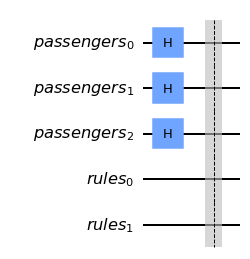

In [ ]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

RULES=2

q_pass=QuantumRegister(QUBITS, name='passengers')
q_rules=QuantumRegister(RULES, name='rules')
qc=QuantumCircuit(q_pass, q_rules)

qc.h(q_pass)
qc.barrier()

qc.draw('mpl')


In [ ]:
def oracle(passenger, group, q_p, q_r, draw=False):
    # Create a sub-circuit
    o_qc = QuantumCircuit(q_p, q_r)

    # loop through all passengers
    for pos in range(0, 2**QUBITS):
        if pos >= len(group.index):
            break

        bpos = encode(pos)
        
        # select the state representing the passenger
        select_state(bpos, o_qc, q_p)

        # apply the rules
        apply_rules(passenger, group.iloc[[pos]], o_qc, q_p, q_r)

        # un-select the state representing the passenger
        select_state(bpos, o_qc, q_p)

        if draw:
            o_qc.barrier()

    if draw:
        return o_qc.draw("mpl")
    else:
        # We return the oracle as a gate
        Oracle = o_qc.to_gate()
        Oracle.name = "oracle"
        return Oracle

In [ ]:
def select_state(bpos, qc, qubits):
  for i in range(0, QUBITS):
    if bpos[::-1][i]=="0":
      qc.x(qubits[i])

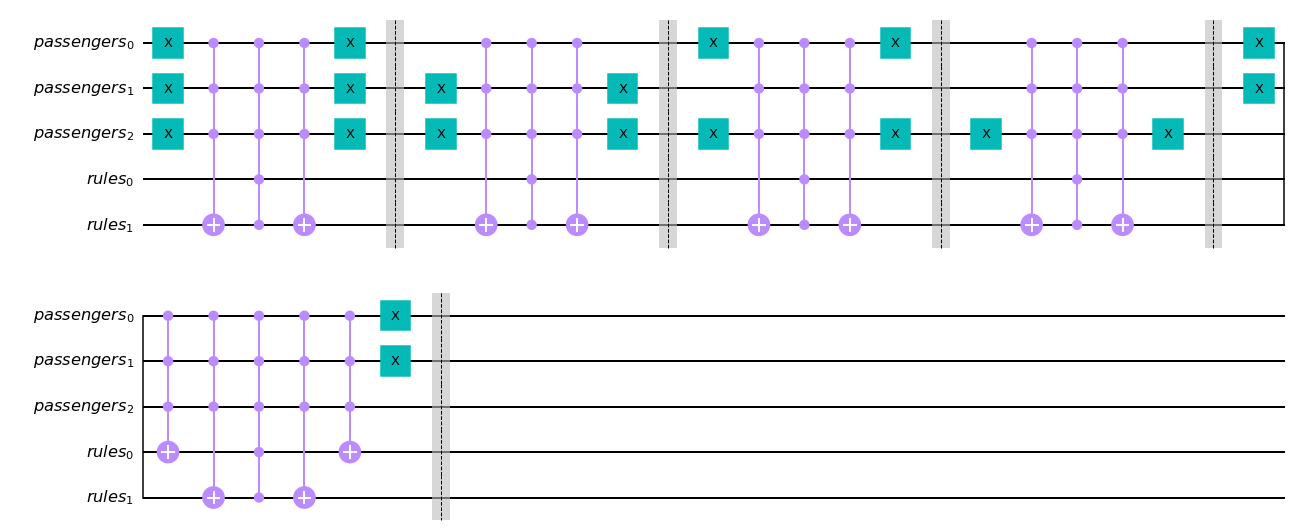

In [ ]:
from qiskit.circuit.library import ZGate

def apply_rules(passenger, current, qc, q_p, q_r):
  # First rule: Ticket number
  if passenger["Ticket"].to_string(index=False).lstrip()==current["Ticket"].to_string(index=False).lstrip():
    qc.mcx(q_p, q_r[0])

  # Second rule: Last Names
  if passenger["Name"].to_string(index=False).split(',')[0].lstrip()==current["Name"].to_string(index=False).split(',')[0].lstrip():
    qc.mcx(q_p, q_r[1])
  
  # Apply C-Z gate to flip amplitudes for those whose all states except target are 1 (=QUBITS+RULES - 1)
  # [*q_p, *q_r] is list and * unfolds it into single items
  qc.append(ZGate().control(QUBITS+RULES-1), [*q_p, *q_r])

  # Un-apply second rule
  if passenger["Name"].to_string(index=False).split(',')[0].lstrip()==current["Name"].to_string(index=False).split(',')[0].lstrip():
    qc.mcx(q_p, q_r[1])

  # Un-apply First rule
  if passenger["Ticket"].to_string(index=False).lstrip()==current["Ticket"].to_string(index=False).lstrip():
    qc.mcx(q_p, q_r[0])

oracle(current_passenger, group, q_pass, q_rules, True)

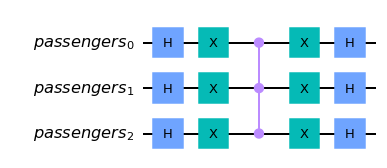

In [ ]:
def amplifier(passeger, q_p, draw=False):
  a_qc=QuantumCircuit(q_p)

  a_qc.h(q_p)
  a_qc.x(q_p)
  a_qc.append(ZGate().control(QUBITS-1), q_p)
  a_qc.x(q_p)
  a_qc.h(q_p)

  if draw:
    return a_qc.draw("mpl")
  else:
    Amplifier=a_qc.to_gate()
    Amplifier.name="amplifier"
    return Amplifier
    
amplifier(passenger, q_pass, draw=True)

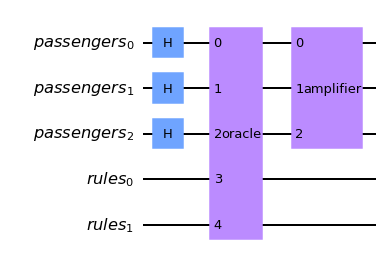

In [ ]:
qc=QuantumCircuit(q_pass, q_rules)

qc.h(q_pass)
qc.append(oracle(current_passenger, group, q_pass, q_rules), [*q_pass, *q_rules])
qc.append(amplifier(current_passenger, q_pass), q_pass)
qc.draw("mpl")

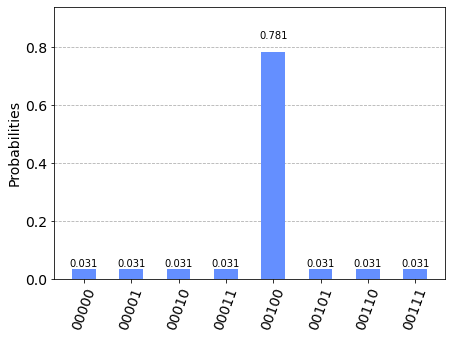

In [ ]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

results=execute(qc, Aer.get_backend('statevector_simulator')).result()
plot_histogram(results.get_counts())

In [ ]:
## apply amplifier pi/4*sqrt(N(qubits))

def rounds(number_of_rounds, qc, current_passenger, group, q_pass, q_rules):
  print("{} iterations".format(number_of_rounds))
  for i in range(0, round(number_of_rounds)):
    qc.append(oracle(current_passenger, group, q_pass, q_rules), [*q_pass, *q_rules])
    qc.append(amplifier(current_passenger, q_pass), q_pass)


In [ ]:
from math import pi, sqrt
qc=QuantumCircuit(q_pass,q_rules)
qc.h(q_pass)
rounds(pi*sqrt(2**QUBITS)/4, qc, current_passenger, group, q_pass, q_rules)
qc.draw()

2.221441469079183 iterations


┌───┐┌─────────┐┌────────────┐┌─────────┐┌────────────┐
passengers_0: ┤ H ├┤0        ├┤0           ├┤0        ├┤0           ├
              ├───┤│         ││            ││         ││            │
passengers_1: ┤ H ├┤1        ├┤1 amplifier ├┤1        ├┤1 amplifier ├
              ├───┤│         ││            ││         ││            │
passengers_2: ┤ H ├┤2 oracle ├┤2           ├┤2 oracle ├┤2           ├
              └───┘│         │└────────────┘│         │└────────────┘
     rules_0: ─────┤3        ├──────────────┤3        ├──────────────
                   │         │              │         │              
     rules_1: ─────┤4        ├──────────────┤4        ├──────────────
                   └─────────┘              └─────────┘

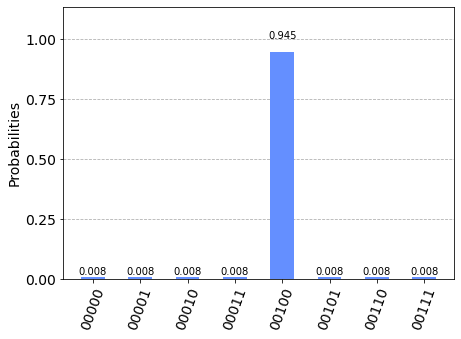

In [ ]:
results=execute(qc, Aer.get_backend('statevector_simulator')).result()
plot_histogram(results.get_counts())

3.221441469079183 iterations


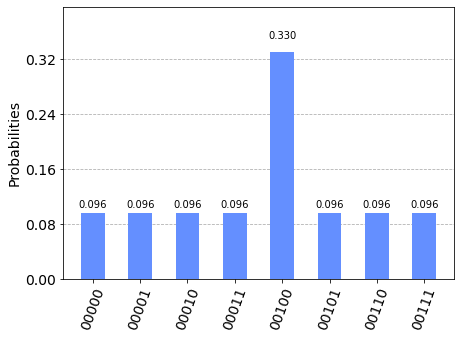

In [ ]:
## If iterated more than pi/4*sqrt(N)
from math import pi, sqrt
qc=QuantumCircuit(q_pass,q_rules)
qc.h(q_pass)
rounds(pi*sqrt(2**QUBITS)/4+1, qc, current_passenger, group, q_pass, q_rules)
results=execute(qc, Aer.get_backend('statevector_simulator')).result()
plot_histogram(results.get_counts())

In [19]:
### 10 passengers

QUBITS=10

q_pass = QuantumRegister(QUBITS, name='passengers')
q_rules = QuantumRegister(RULES, name='rules')
qc = QuantumCircuit(q_pass, q_rules)

# put passenger qubits into superposition
qc.h(q_pass)
rounds(pi*sqrt(2**QUBITS)/4, qc, current_passenger, group, q_pass, q_rules)
results = execute(qc,Aer.get_backend('statevector_simulator')).result()
"Probability of finding '100': {}".format(results.get_counts()['000000000100'])

25.132741228718345 iterations


"Probability of finding '100': 0.999461244728393"

### Multilple results

In [20]:
def prepare_group(passengerId):
 current_passenger = train[train["PassengerId"].eq(passengerId)]
 last_name = current_passenger.Name.to_string(index=False).split(',')[0].lstrip()
 train[train["Name"].str.contains(last_name)]

 ticket = current_passenger["Ticket"].to_string(index=False).lstrip()
 passengerId = current_passenger["PassengerId"]

 group = train[
    train["PassengerId"].ne(passengerId) & (
    train["Name"].str.contains(last_name) |
    train["Ticket"].eq(ticket)
    )]
 return (current_passenger, group)

1.282549830161864 iterations


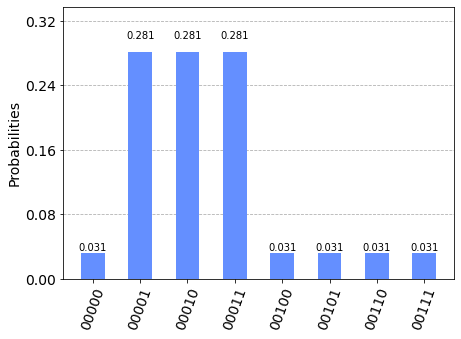

In [21]:
# Iterate pi/4(sqrt(N/M)) times to search for M results

def find_relatives(current_passenger, group, cnt_searched):
    q_pass = QuantumRegister(QUBITS, name='passengers')
    q_rules = QuantumRegister(RULES, name='rules')
    qc = QuantumCircuit(q_pass, q_rules)

    # put passenger qubits into superposition
    qc.h(q_pass)
    rounds(pi/4*sqrt(2**QUBITS/cnt_searched), qc, current_passenger, group, q_pass, q_rules)
    results = execute(qc,Aer.get_backend('statevector_simulator')).result()
    return plot_histogram(results.get_counts())

QUBITS=3
(current_passenger, group) = prepare_group(391)
find_relatives(current_passenger, group, current_passenger["SibSp"]+current_passenger["Parch"])